# Linear Models and Interpretability

This notebook explores the interpretability of a linear models using a Kaggle toy dataset.

Outline: 
- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Modeling](#modeling)
- [Comparison of Models](#comparison-of-models)
- [Recommendation](#recommendation)

## Exploratory Data Analysis 

This section covers an exploratory analysis of the dataset. 

In [68]:
%pip install pygam 

Note: you may need to restart the kernel to use updated packages.


In [69]:
import numpy as np 
import pandas as pd
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns

### Dataset

The target of the analysis is the Kaggle **Telco Customer Churn** dataset (https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data). From the dataset page on Kaggle: 

**Context**
*"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]*

**Content**
*Each row represents a customer, each column contains customer’s attributes described on the column Metadata.*

**The data set includes information about:**
- *Customers who left within the last month – the column is called Churn*
- *Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies*
- *Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges*
- *Demographic info about customers – gender, age range, and if they have partners and dependents*

In [70]:
# NOTE: this cell straight from the Kaggle project
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /Users/jason/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


In [71]:
!ls $path

WA_Fn-UseC_-Telco-Customer-Churn.csv


In [72]:
df = pd.read_csv(path + f"/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [73]:
assert(len(df.customerID.unique()) == len(df))

The dataset provides features about a customer, with one row per customer (who are each uniquely identified by the `customerID` column), and are now redundant given our index. 

In [74]:
df.drop(['customerID'], axis=1, inplace=True) 

### Characterize Predictors

Next we'll inspect the predictor variables and characterize their distribution as well as their relationship to one another. To do this we need to decompose and re-encode the categoricals in a method suitable for numerical comparisons. 

In [75]:
from sklearn.preprocessing import binarize, label_binarize, OneHotEncoder

In [76]:
for col in df.columns: 
    if df[col].dtype == 'object': 
        print(f"{col}: {df[col].unique()}")

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges: ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn: ['No' 'Yes']


We need to transform our features to support this analysis as well as later modeling. Copy the DF so we can retain both representations. 

In [77]:
dfm = df.copy()

In [78]:
dfm.gender = label_binarize(df.gender, classes=df.gender.unique())
dfm.Partner = label_binarize(df.Partner, classes=df.Partner.unique())
dfm.Dependents = label_binarize(df.Dependents, classes=df.Dependents.unique())
dfm.PhoneService = label_binarize(df.PhoneService, classes=df.PhoneService.unique())
dfm.PaperlessBilling = label_binarize(df.PaperlessBilling, classes=df.PaperlessBilling.unique())
dfm.Churn = label_binarize(df.Churn, classes=df.Churn.unique())

In [79]:
def onehot_encode(df, column, drop_source=True): 
    """
    One-hot encode the target column
    """
    enc = OneHotEncoder(handle_unknown='error', sparse_output=False)
    onehot = enc.fit_transform(df.loc[:,[column]])
    for i, feature in enumerate(enc.get_feature_names_out()): 
        df[feature] = onehot[:,i]

    return df.drop([column], axis=1) if drop_source else df

In [80]:
dfm = onehot_encode(dfm, 'MultipleLines')
dfm = onehot_encode(dfm, 'InternetService')
dfm = onehot_encode(dfm, 'OnlineSecurity')
dfm = onehot_encode(dfm, 'OnlineBackup')
dfm = onehot_encode(dfm, 'DeviceProtection')
dfm = onehot_encode(dfm, 'TechSupport')
dfm = onehot_encode(dfm, 'StreamingTV')
dfm = onehot_encode(dfm, 'StreamingMovies')
dfm = onehot_encode(dfm, 'Contract')
dfm = onehot_encode(dfm, 'PaymentMethod')

In [81]:
dfm.TotalCharges = df.TotalCharges.apply(lambda x: 0 if x==' ' else x)
dfm.TotalCharges = dfm.TotalCharges.astype(float)

In [82]:
dfm

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,0,0,1,0,0,29.85,29.85,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,1,0,34,1,1,56.95,1889.50,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,0,1,0,2,1,0,53.85,108.15,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,1,0,45,0,1,42.30,1840.75,0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0,0,1,0,2,1,0,70.70,151.65,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,0,1,24,1,0,84.80,1990.50,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7039,0,0,0,1,72,1,0,103.20,7362.90,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7040,0,0,0,1,11,0,0,29.60,346.45,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7041,1,1,0,0,4,1,0,74.40,306.60,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


**Distribution** 
Here we plot a histogram of the categoricals and continuous predictors to get an appreciation for the distribution of each. 

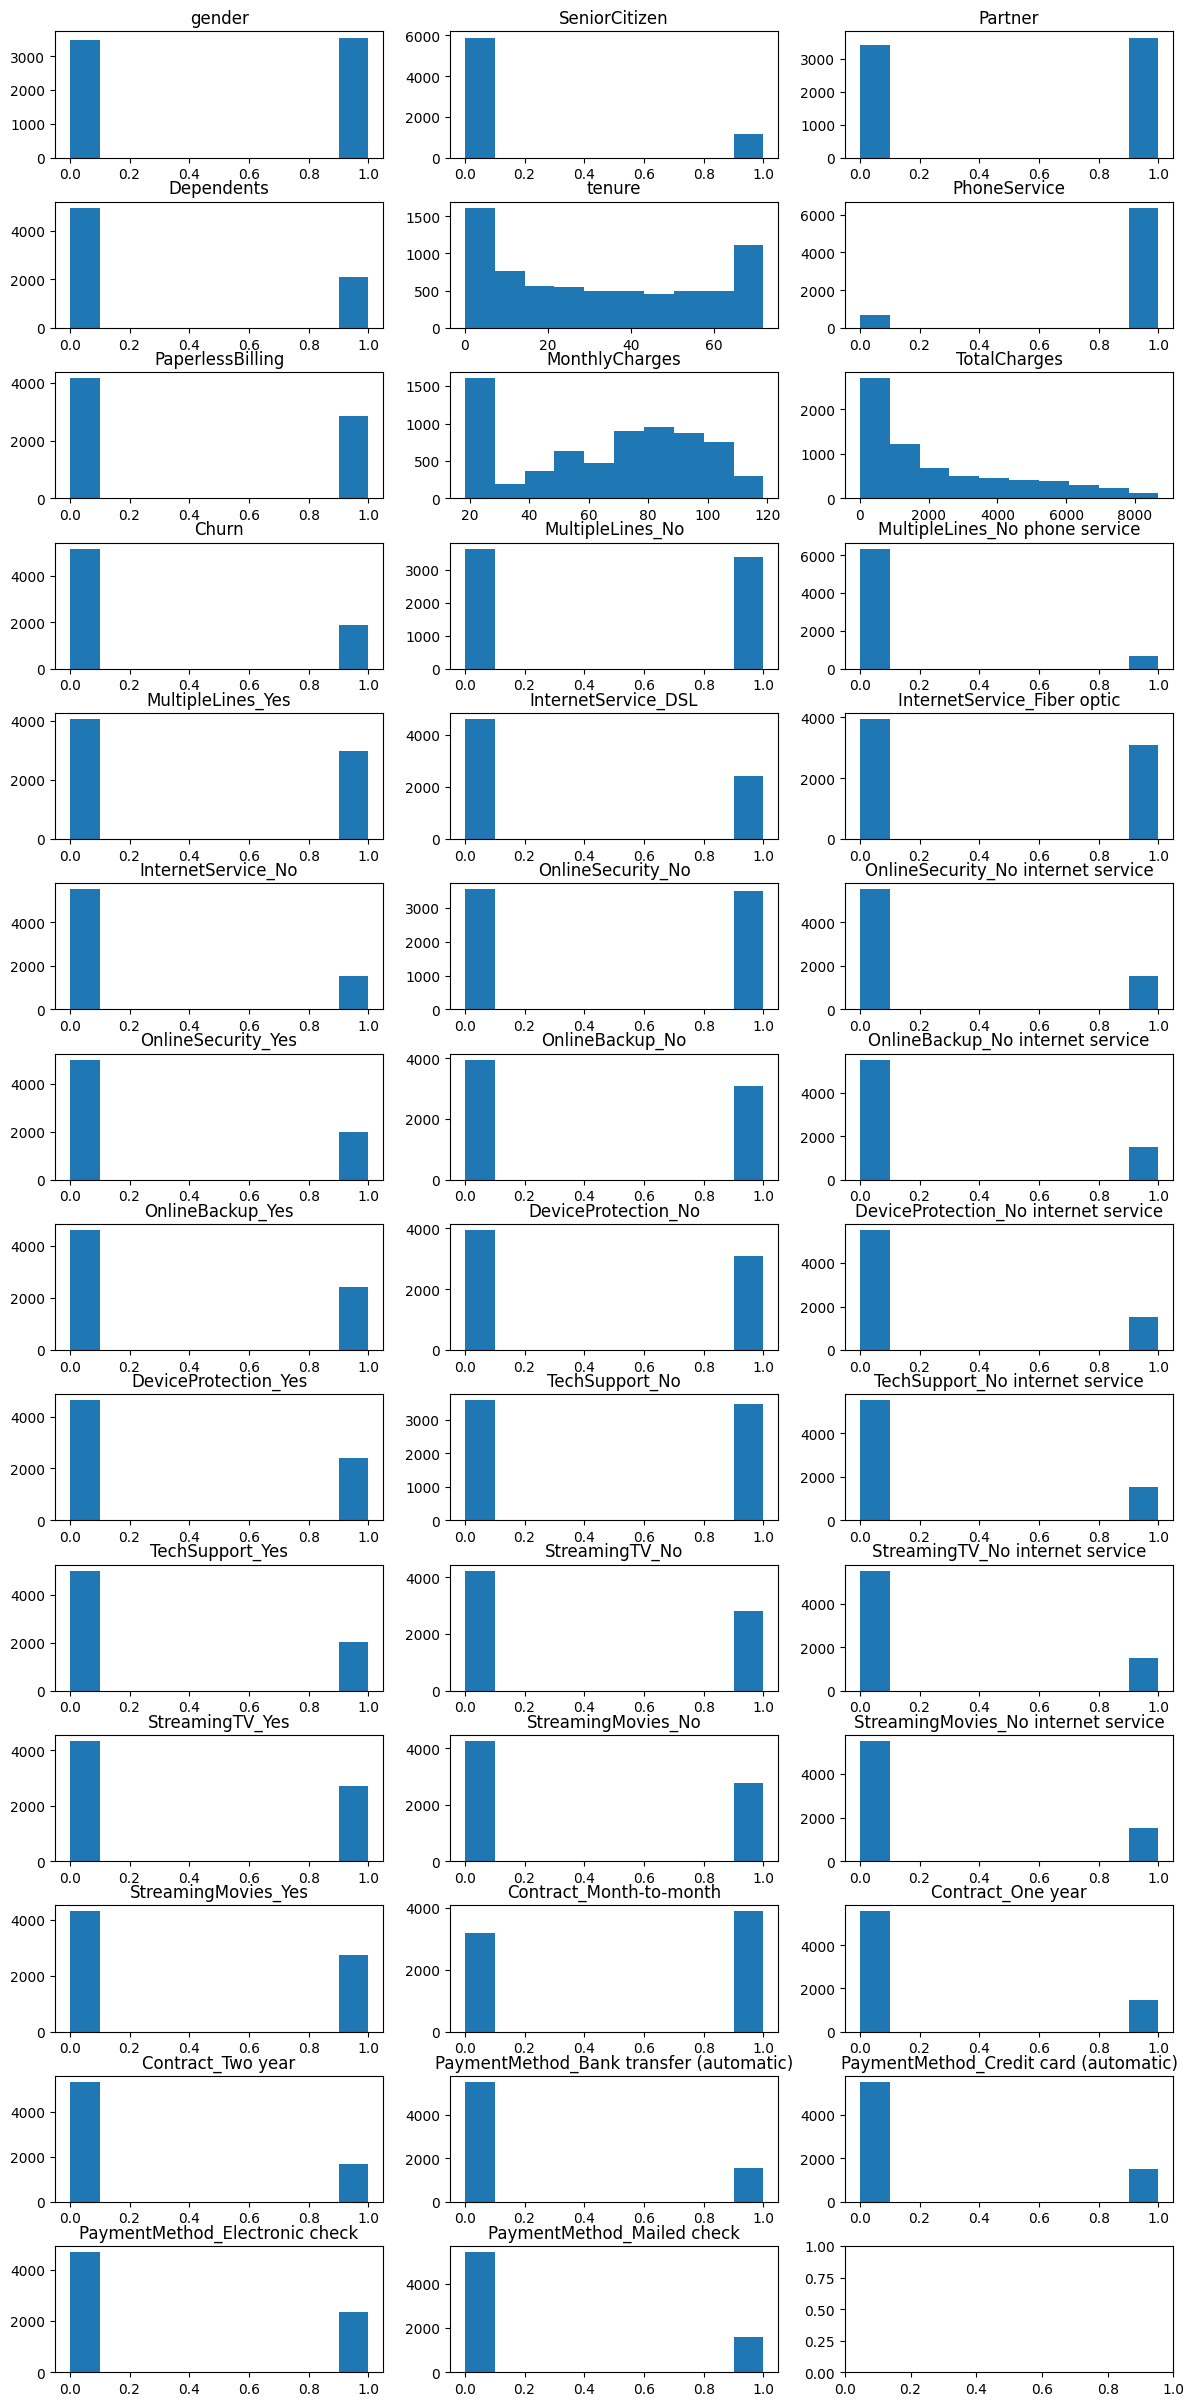

In [83]:
# Plot the distribution of all variables and the target
features = dfm.columns
h = 14
w = 3
fig, axs = plt.subplots(h,w, figsize=(12,24))
fig.tight_layout()
for i, feature in enumerate(features): 
     row = i // w
     col = i % w
     axs[row, col].hist(dfm[feature])
     axs[row, col].set_title(feature)
     
plt.show()

While it's useful to understand the degree to which the categorical classes are balanced, there's not much of an intervention to do here as we're only studying model interpretability. 

**Linearity Check** 

Inspect the predictors' relationship with the target. 

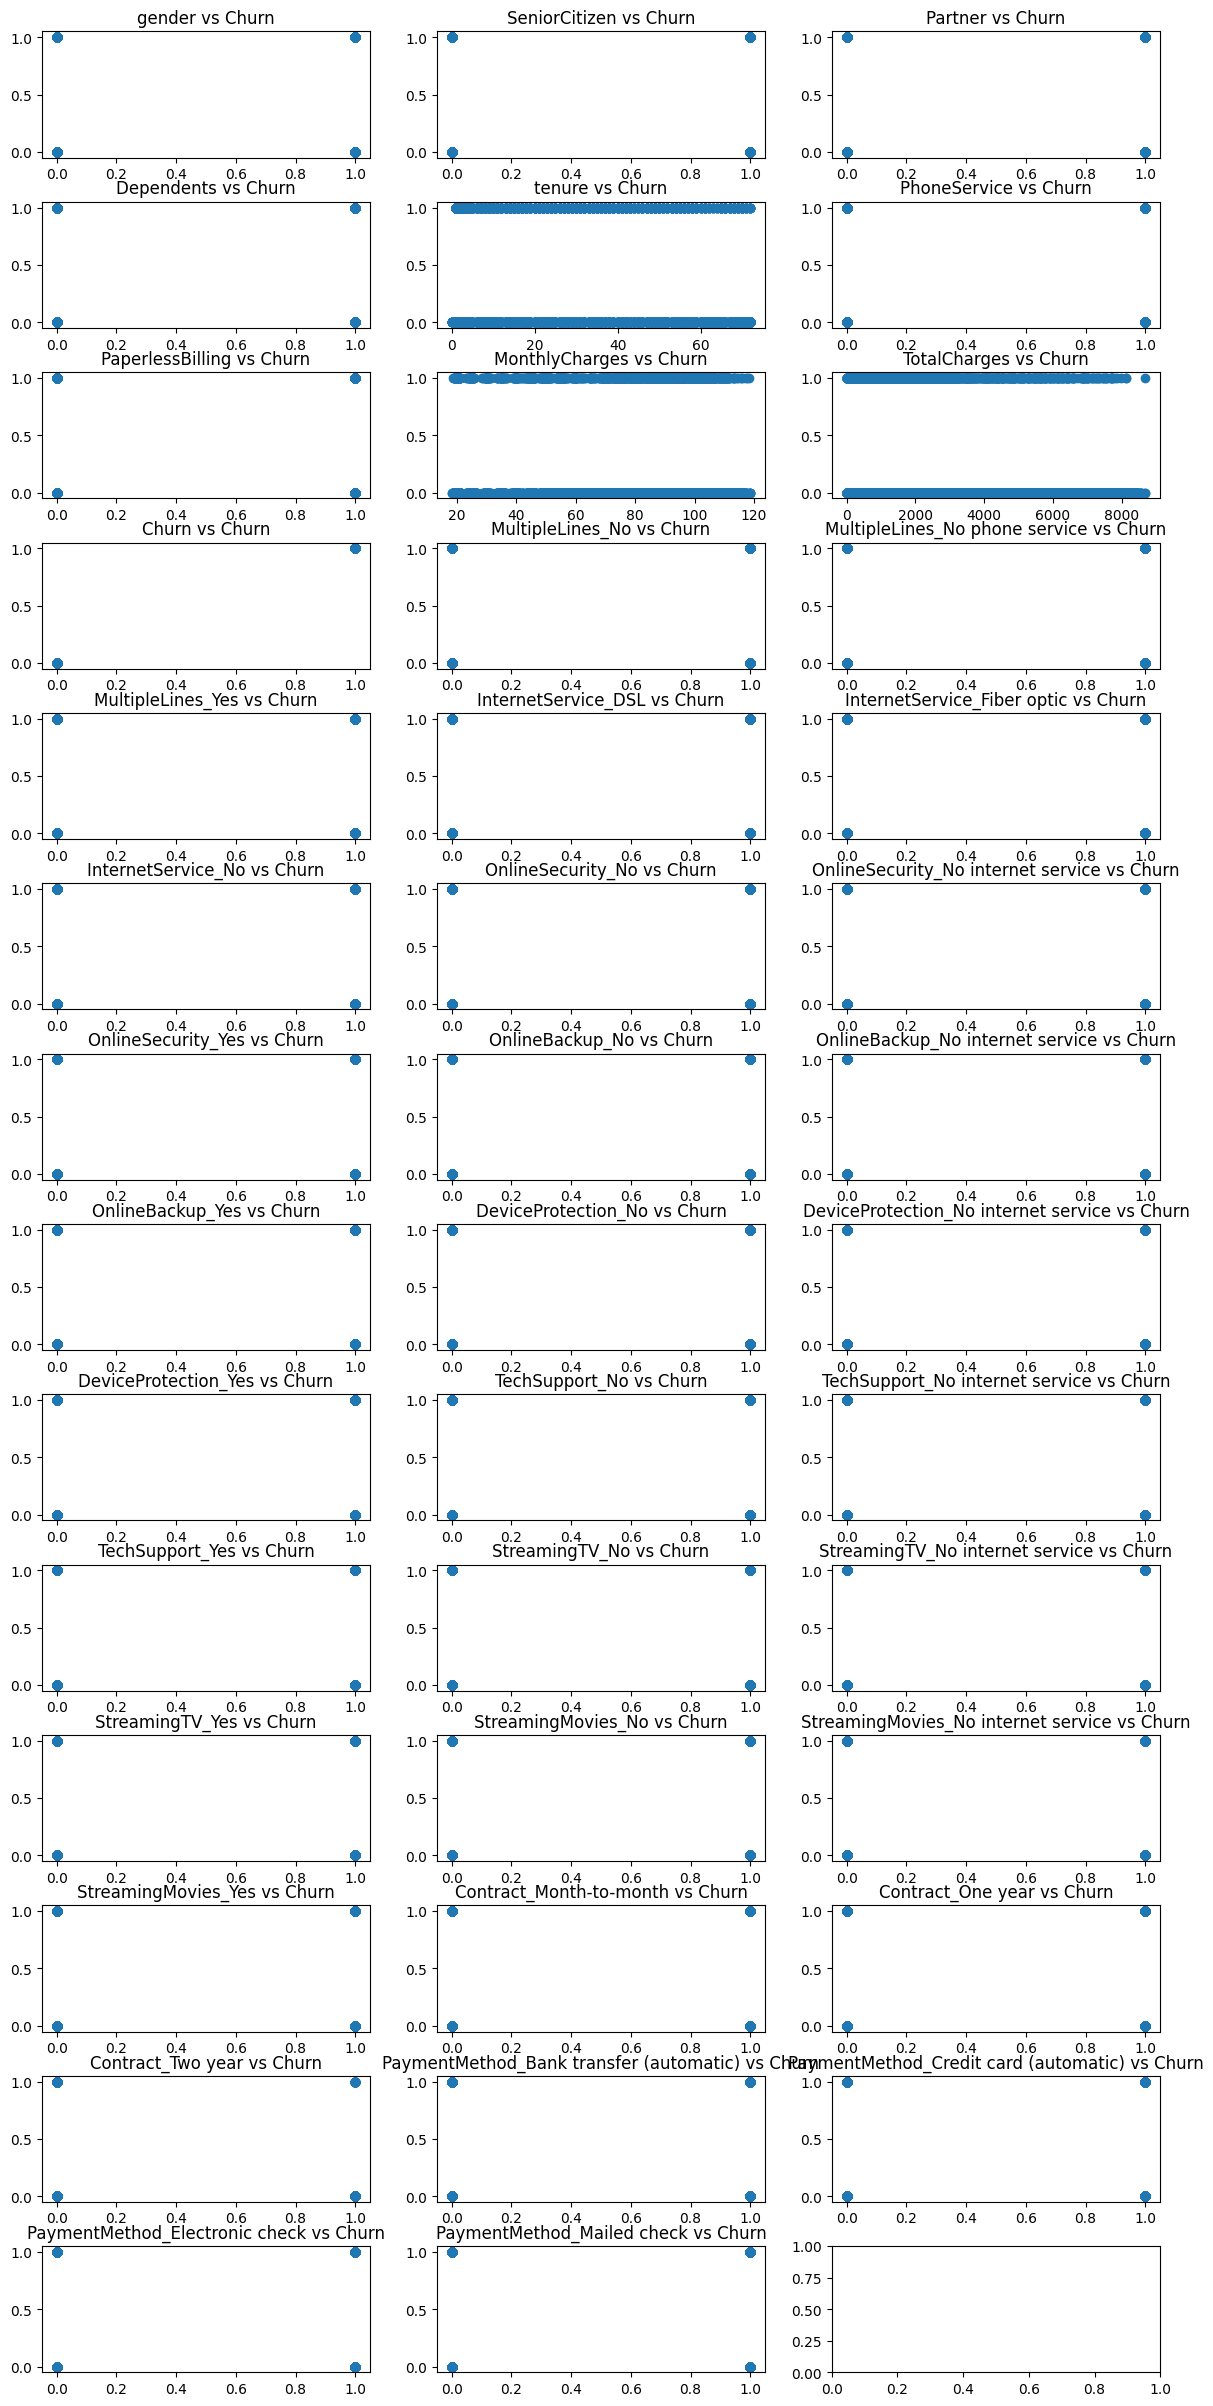

In [84]:
features = dfm.columns
target = "Churn"
h = 14
w = 3
fig, axs = plt.subplots(h,w, figsize=(12,24))
fig.tight_layout()
for i, feature in enumerate(features): 
     row = i // w
     col = i % w
     axs[row, col].scatter(x=dfm[feature], y=dfm[target])
     axs[row, col].set_title(f"{feature} vs {target}")
     
plt.show()
     

The bulk of our predictors are categoricals as is our target. Even after unpacking to more precisely represent the respective dimensions, we 

**Independence** 

To test independence we need a numerical representation of each feature. Inventory the unique values and encode using the appropriate method (binarize or one-hot)

In [85]:
cm = dfm.corr()


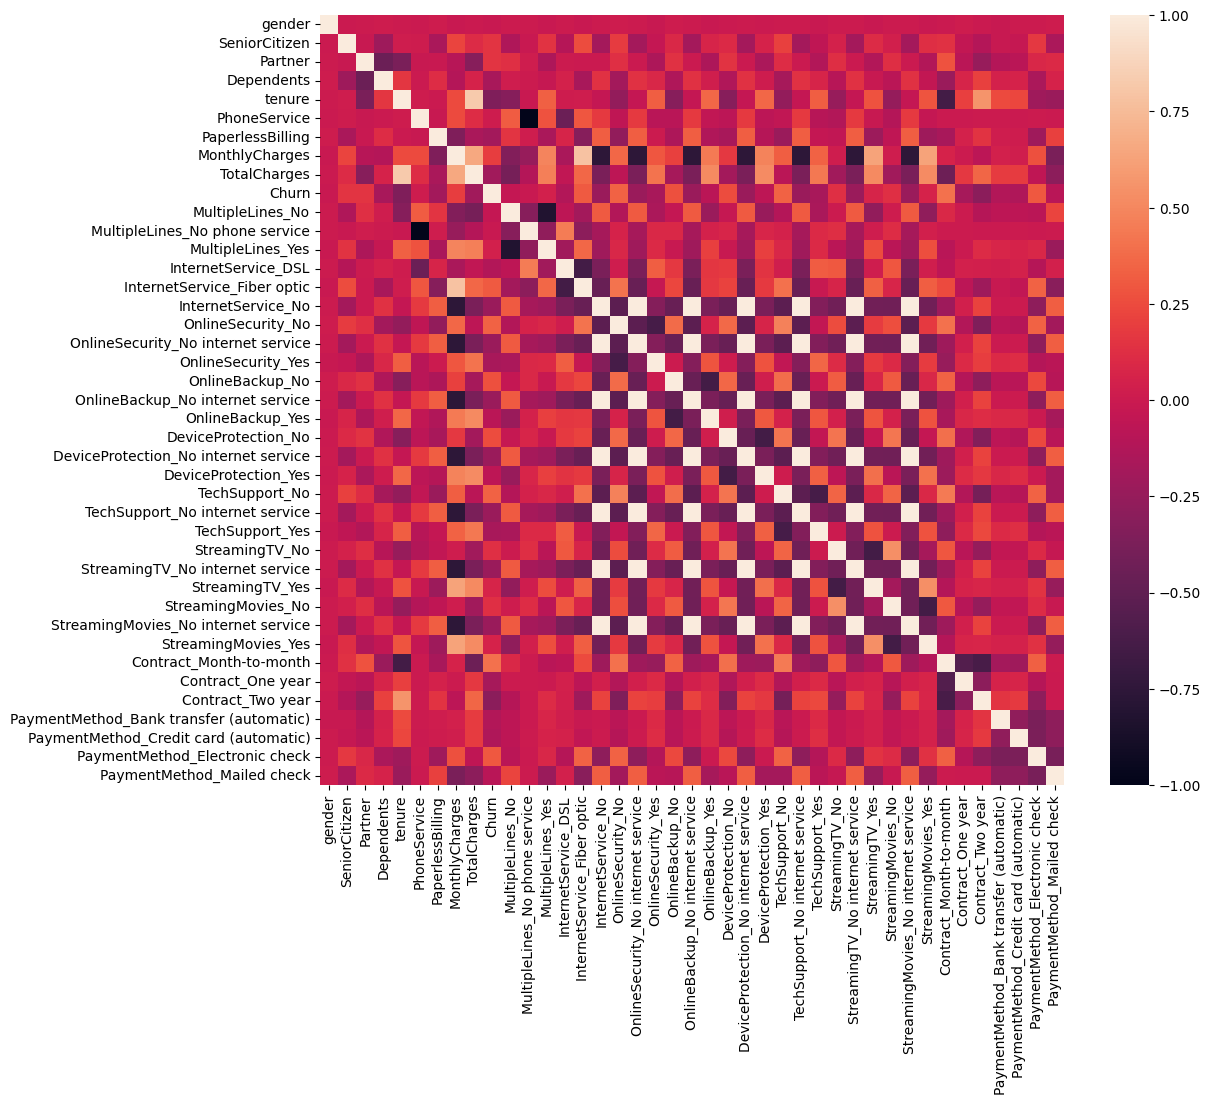

In [86]:
plt.figure(figsize=(12, 10))
_ = sns.heatmap(cm)

With an idea of what correlations exist, and there are clearly some minor ones, we threshold to determine the most problematic. 

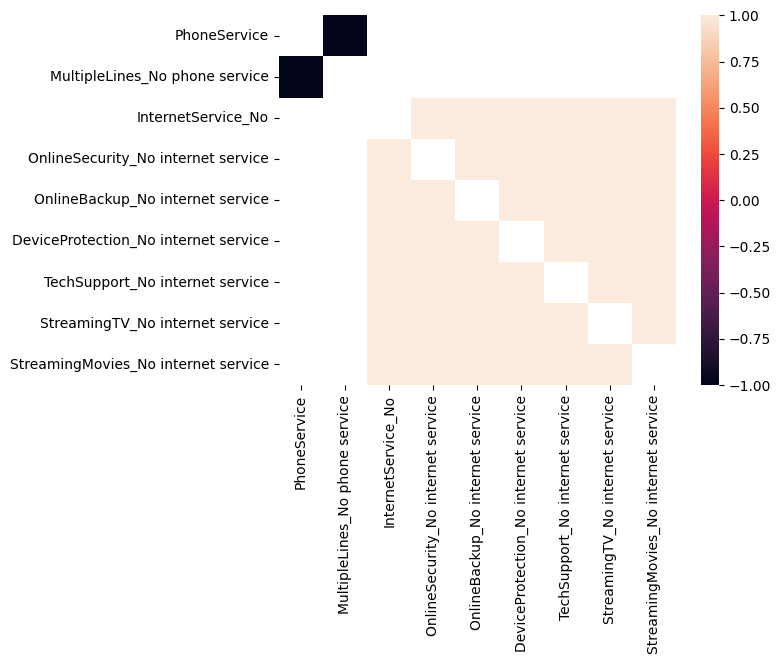

In [87]:
np.fill_diagonal(cm.to_numpy(), 0)
cm_thresh = cm[(cm > 0.85) | (cm <-0.85)]
cm_thresh = cm_thresh.dropna(how='all')
cm_thresh = cm_thresh.dropna(how='all', axis=1)
_ = sns.heatmap(cm_thresh)

In [88]:
cm_thresh.columns

Index(['PhoneService', 'MultipleLines_No phone service', 'InternetService_No',
       'OnlineSecurity_No internet service',
       'OnlineBackup_No internet service',
       'DeviceProtection_No internet service',
       'TechSupport_No internet service', 'StreamingTV_No internet service',
       'StreamingMovies_No internet service'],
      dtype='object')

Here we can see that: 
1. The presence or absence of Internet service is correlated to the analogous value in a number of categorical features. This correlation is unambiguous and is a redundant coding for the same variable (lack of Internet). We'll remove the associated feature to get a clearer picture of the relationship between the remaining one-hot features, which do not exhibit any strong correlation. 
2. The lack of multiple phone lines is 100% correlated to users who have no phone service. This is also a redundant coding and we'll remove. 

In [89]:
dfm.drop([
    'MultipleLines_No phone service', 
    'OnlineSecurity_No internet service',
    'OnlineBackup_No internet service',
    'DeviceProtection_No internet service',
    'TechSupport_No internet service', 
    'StreamingTV_No internet service',
    'StreamingMovies_No internet service'
    ], axis=1, inplace=True)

**Homesceadisticity**

Here we need residuals, this is discussed in the modeling phase where applicable. 

**Normality**

Also need residuals, see below in modeling phase. 

Categorical variables don't lend themselve to a distributional analysis due to the lack of values and the irrelevance of the ordering. The handful of real-valued predictors we have in `MonthlyCharges`, `tenure` and `TotalCharges` do not follow a Gaussian distribution pattern

**Outliers**

Here we look for any outliers that may have an outside influence on our modeling. Per the above section where we examine distribution, only `tenure` and `MonthlyCharges` appear to be at risk for outliers. 

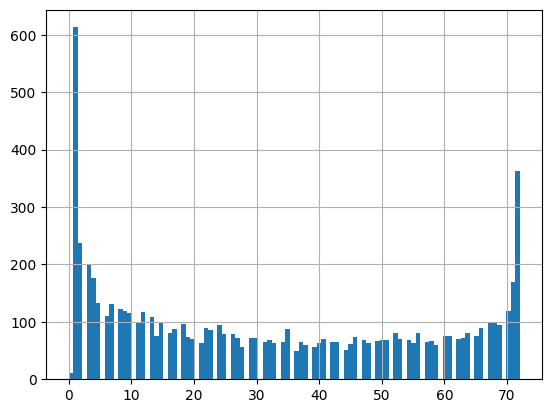

In [90]:
_ = dfm.tenure.hist(bins=100)

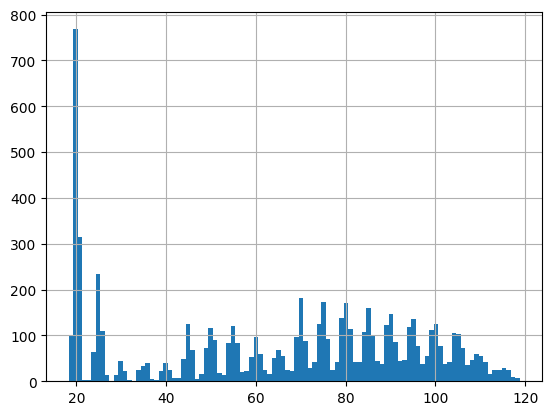

In [91]:
_ = df.MonthlyCharges.hist(bins=100)

The above plots make it clear that we don't have outlier, as odd as the distribution pattern is. We conclude we have met our expectations surrounding outliers and no further cleaning or transformations are required. 

## Modeling

In this section we'll move on to modeling using the conditioned features from above. We consider three models
1. Linear Regression
2. Logistic Regression
3. Generalized Additive Model (GAM)

All models aim to predict the customer `churn` value. We'll first separate our data into predictors we can train on and a target. 

In [92]:
X = dfm.drop(['Churn'], axis=1)
y = dfm.Churn

While linear models are robust to data of varying scales, and scaling introduces a term we must keep track of if we want to understand the impact on our input values, the explainability of our model's learned coefficients suffers if we do not normalize. That is, without a level playing field, we have to individually consider the range and scale of each predictor when we look at learned coefficients. In short, we scale our data here. 

In [93]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

We need to hold data out to later conduct a fair comparison on. Because we don't plan on fine-tuning the parameters of the individual models, we skip the creation of a distinct validation set and just rely on a 80/20 train/test split. 

In [94]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=0)

### Linear Regression

We'll use a linear regression implementation from the Sci-kit Learn library. Specifically we employ the [LinearRegression estimator](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression). 

In [95]:
from sklearn.linear_model import LinearRegression 

model = LinearRegression()
model.fit(X=X_train, y=y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


After fitting we can inspect the learned bias and coefficients for each of our input features: 

In [96]:
print(f"Fit model equation:\n {model.intercept_:.3f} + ")
for feature, coef in zip(X.columns, model.coef_):
    print(f" + {feature} * {coef:.3f}")

Fit model equation:
 0.266 + 
 + gender * -0.005
 + SeniorCitizen * 0.017
 + Partner * -0.002
 + Dependents * -0.013
 + tenure * -0.050
 + PhoneService * -0.012
 + PaperlessBilling * -0.023
 + MonthlyCharges * 0.072
 + TotalCharges * -0.101
 + MultipleLines_No * -0.016
 + MultipleLines_Yes * 0.009
 + InternetService_DSL * -0.023
 + InternetService_Fiber optic * 0.031
 + InternetService_No * -0.011
 + OnlineSecurity_No * 0.018
 + OnlineSecurity_Yes * -0.010
 + OnlineBackup_No * 0.016
 + OnlineBackup_Yes * -0.007
 + DeviceProtection_No * 0.007
 + DeviceProtection_Yes * 0.002
 + TechSupport_No * 0.018
 + TechSupport_Yes * -0.009
 + StreamingTV_No * -0.004
 + StreamingTV_Yes * 0.013
 + StreamingMovies_No * 0.001
 + StreamingMovies_Yes * 0.009
 + Contract_Month-to-month * 0.027
 + Contract_One year * -0.025
 + Contract_Two year * -0.007
 + PaymentMethod_Bank transfer (automatic) * -0.008
 + PaymentMethod_Credit card (automatic) * -0.012
 + PaymentMethod_Electronic check * 0.025
 + PaymentMe

To appreciate the suitability of the fit model, we start by charting the predictions and residual errors on the *training data*. This helps us appreciate the impact of model bias.

In [97]:
y_pred = model.predict(X_test)

We can naively compare our predictor to our output class

Text(0.5, 1.0, 'Target vs Predicted Customer Churn,\nLinear Regression Model')

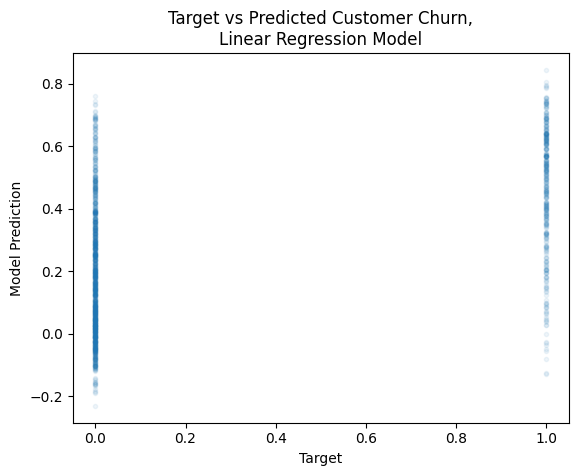

In [98]:
plt.scatter(x=y_test, y=y_pred, marker='.', alpha=0.07)
plt.xlabel('Target')
plt.ylabel('Model Prediction')
plt.title('Target vs Predicted Customer Churn,\nLinear Regression Model')

This is a suboptimal way to interpret our predictions given the density of the plots. However, the transparency suggests we have a problem: Even with thoughtful thresholding of the output value we have significant overlap in the positive and negative classes that we're predicting. 

Looking at the distribution of the predictions reinforces our instinct. There aren't two clear modes we can bisecting with a simple threshold for positive and negative churn predictions. 

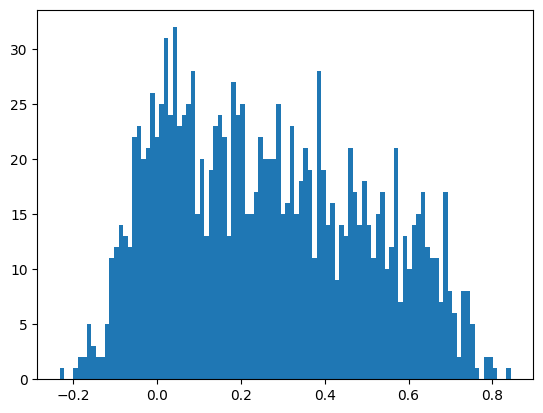

In [99]:
_ = plt.hist(y_pred, bins=100)

Still, we can examine what is essentially a binary classifier by looking at how the true positive and false positive rates shift with a varying threshold and report the area under the receiver operator characteristics (ROC) curve. 

In [100]:
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

score = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {score:.3f}")

ROC AUC Score: 0.815


And then plot the curve to get an instinct for the how the threshold changes our true + false positive rates. 

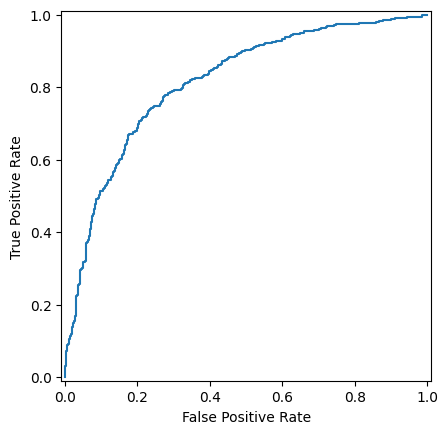

In [101]:
# Note ROC curve interface syntax courtesy of docs @ https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_display_object_visualization.html#sphx-glr-auto-examples-miscellaneous-plot-display-object-visualization-py
fpr, tpr, _ = roc_curve(y_test, y_pred)
rcd = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

Given the characteristic bulge in the curve at the midpoint of the curve, we select a threshold of 0.5 to balance our classifier/regression and check the confusion matrix. 

In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

def threshold_predictions(preds, threshold=0.5): 
    """
    Threshodl the provided predictions and return the new positive and negative classes
    """
    result = np.zeros(len(preds))
    result[preds >= threshold] = 1.0
    return result

def plot_confusion_matrix(y, y_hat): 
    """
    Render a confusion matrix 
    """
    conmat = confusion_matrix(y, y_hat)
    cmd = ConfusionMatrixDisplay(confusion_matrix=conmat)
    cmd.plot()

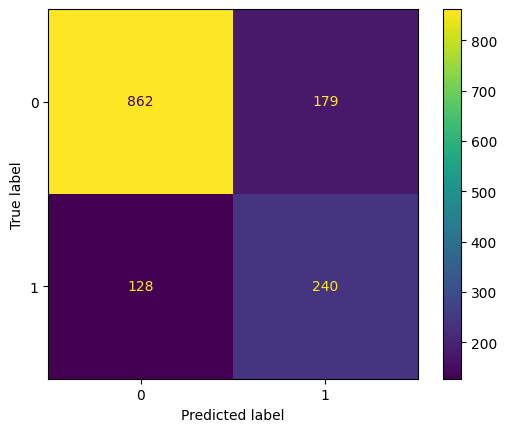

In [103]:
y_binary_pred = threshold_predictions(y_pred, threshold=0.4)
plot_confusion_matrix(y_test, y_binary_pred)

At our selected threshold, the regression estimator is our baseline for performance. We'll use the F1 score, which captures the precision and recall of the model and can be applied to the output of the subsequent models.

In [104]:
f1 = f1_score(y_test, y_binary_pred)
print(f"F1 score for linear regression @ threshold: {f1:.3f}")

acc = accuracy_score(y_test, y_binary_pred)
print(f"Accuracy score for linear regression @ threshold: {acc:.3f}")

F1 score for linear regression @ threshold: 0.610
Accuracy score for linear regression @ threshold: 0.782


Finally, we look at the distribution of our residual errors and how residuals move with our predicted value. 

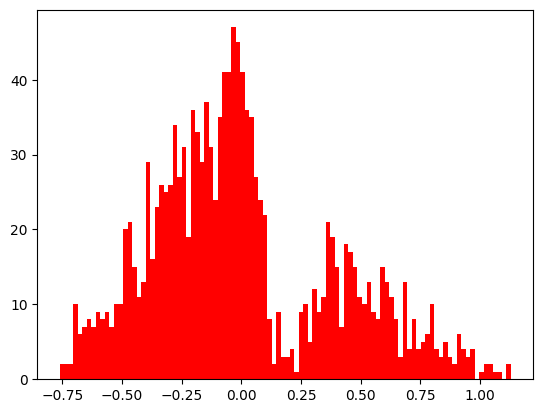

In [105]:
errors = y_test - y_pred
_ = plt.hist(errors, bins=100, color='r')

Text(0, 0.5, 'Prediction Error')

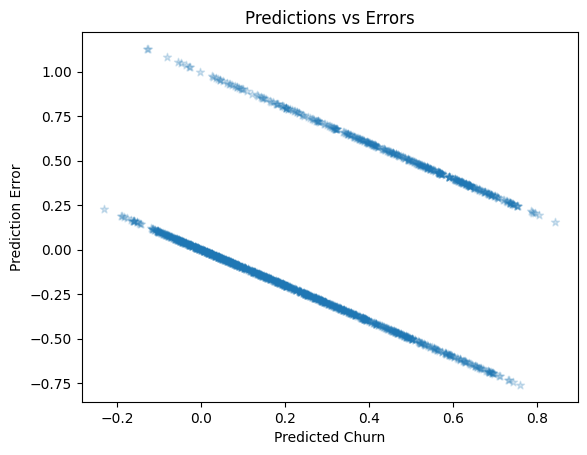

In [106]:
plt.scatter(x=y_pred, y=errors, marker="*", alpha=0.2)
plt.title("Predictions vs Errors")
plt.xlabel("Predicted Churn")
plt.ylabel("Prediction Error")

#### Interpretation

Our model has a straightforward list of coefficients we can evaluate. The dominant factors in the model that contribute to customer churn are plotted below. 

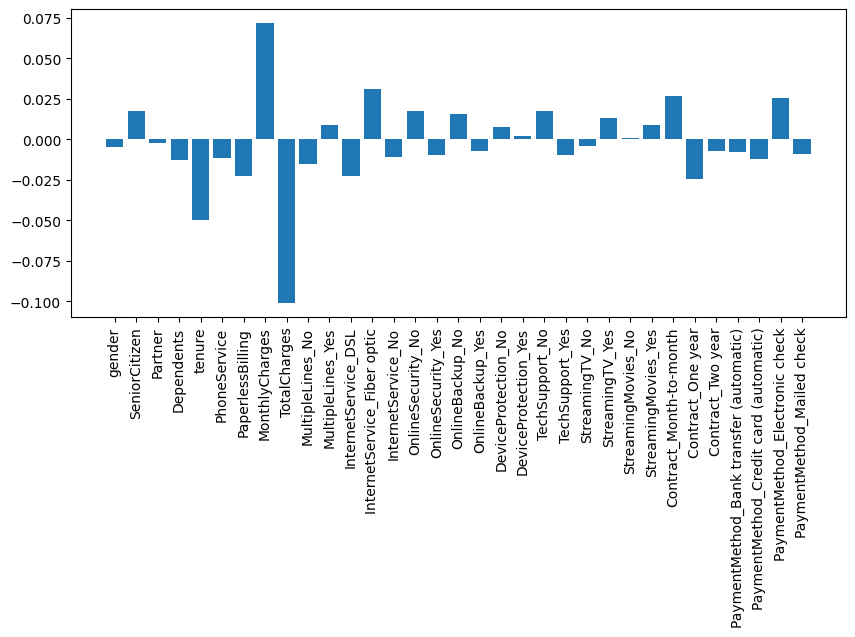

In [107]:
plt.figure(figsize=(10,4))
plt.bar(height=model.coef_,x=X.columns)
plt.xticks(rotation=90)
plt.show()

**Monthly charges** are the dominant factor in predicting customer churn, followed by **fiber optic subscription status** and whether the customer pays **month to month**. The predictors for customer retention are, counterintuitively, the **total charges on their bill**.

In [108]:
def plot_preds(y, y_hat, title=None, n=1000): 
    """
    Plot the first n estimates of target value y 
    """
    samples = range(0,len(y_hat[0:n]))
    errors = y[0:n] - y_hat[0:n]
    plt.figure(figsize=(12,6))
    plt.scatter(x=samples, y=y[0:n], marker='.', label="target", alpha=0.6)
    plt.scatter(x=samples, y=y_hat[0:n], marker='.', label="prediction")
    plt.scatter(x=samples, y=errors, marker='x', color='r', label="error", alpha=0.5)
    plt.title(title)
    plt.legend()
    plt.show()


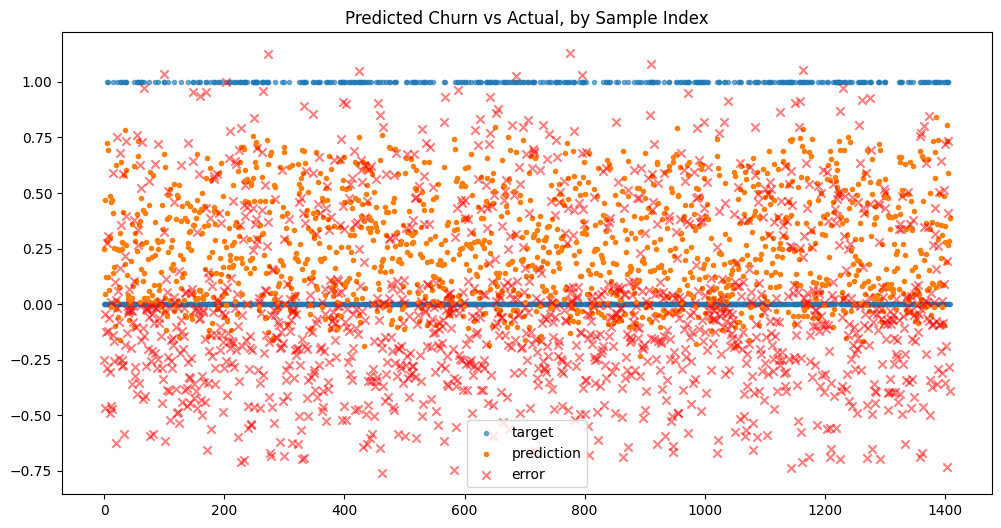

In [109]:
plot_preds(y_test, y_pred, title='Predicted Churn vs Actual, by Sample Index', n=1500)

The ROC AUC and F1 score hint at utility in this model, and the explainability is dead siple. The model does do the job of sometimes predicting `churn` if we allow for thresholding of the output to determine the actual prediction. **However**, as highlighted in the plot above, there are many failure modes (error distribution) and we are heavily reliant on the threshold selection to achieve a passable result. It intuitively feels like linear regression is the wrong model for what amounts to a binary classification task. We return to our prerequisites:  
- **Linearity**: Our predictors don't have a clearly linear relationship to the predictor as shown above
- **Independence**: Our observations do appear to be independent and uncorrelated
- **Homoscedacicity**: The variance of our residuals do not seem to move with the prediction, so homoscedacity is upheld
- **Collinearity**: Our observations do not appear to be collinear and are uncorrelated
- **Normality** We have perhaps two distinct gaussian distributions of the residuals, which seems to undermine of the prerequisites 
- **Outliers** Above distributional plots did not indicate presence of influential outliers

This mixed scorecard suggests linear regression is not the optimal algorithm to apply without further interventions, but is very strong on interpretability. 

----- 

### Logistic Regression 

For logistic regression, we'll use the [logistic regression estimator from Sci-kit Learn](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression). 

In [110]:
from sklearn.linear_model import LogisticRegression

In [111]:
model = LogisticRegression()
model.fit(X=X_train, y=y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [112]:
print(f"Fit model equation:\n {model.intercept_[0]:.3f} + ")
for feature, coef in zip(X.columns, model.coef_.flatten()):
    print(f" + {feature} * {coef:.3f}")

Fit model equation:
 -1.747 + 
 + gender * -0.034
 + SeniorCitizen * 0.090
 + Partner * -0.021
 + Dependents * -0.098
 + tenure * -1.457
 + PhoneService * -0.124
 + PaperlessBilling * -0.181
 + MonthlyCharges * 0.081
 + TotalCharges * 0.681
 + MultipleLines_No * -0.112
 + MultipleLines_Yes * 0.039
 + InternetService_DSL * -0.126
 + InternetService_Fiber optic * 0.188
 + InternetService_No * -0.082
 + OnlineSecurity_No * 0.126
 + OnlineSecurity_Yes * -0.065
 + OnlineBackup_No * 0.103
 + OnlineBackup_Yes * -0.037
 + DeviceProtection_No * 0.046
 + DeviceProtection_Yes * 0.023
 + TechSupport_No * 0.119
 + TechSupport_Yes * -0.057
 + StreamingTV_No * -0.023
 + StreamingTV_Yes * 0.092
 + StreamingMovies_No * 0.009
 + StreamingMovies_Yes * 0.060
 + Contract_Month-to-month * 0.310
 + Contract_One year * -0.052
 + Contract_Two year * -0.311
 + PaymentMethod_Bank transfer (automatic) * -0.029
 + PaymentMethod_Credit card (automatic) * -0.082
 + PaymentMethod_Electronic check * 0.126
 + PaymentMe

In [113]:
y_pred = model.predict(X_test)

We can apply the same plot of target value vs predicted and the prediction distrubiotn as with linear regression.  

Text(0.5, 1.0, 'Target vs Predicted Customer Churn,\nLogistic Regression Model')

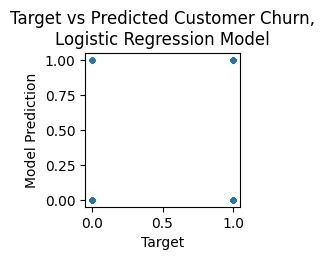

In [114]:
plt.figure(figsize=(2,2))
plt.scatter(x=y_test, y=y_pred, marker='.', alpha=0.07)
plt.xlabel('Target')
plt.ylabel('Model Prediction')
plt.title('Target vs Predicted Customer Churn,\nLogistic Regression Model')

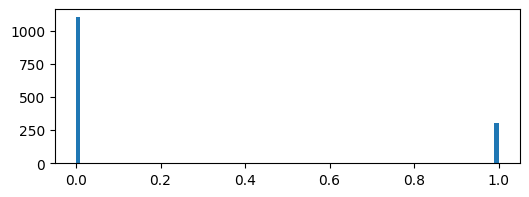

In [115]:
plt.figure(figsize=(6,2))
_ = plt.hist(y_pred, bins=100)

However, these are of little use given the binary output of the logistic regression model. Instead we investigate the confusion matrix as with our thresholded regression estimator. 

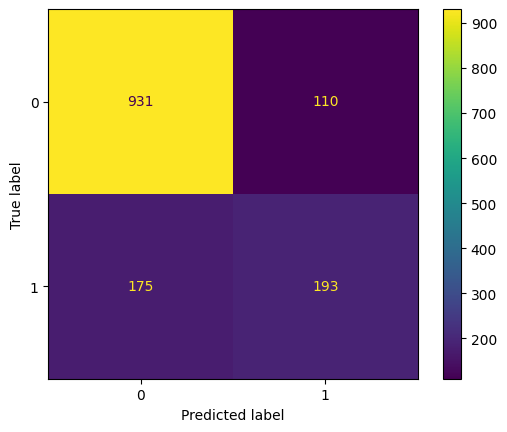

In [116]:
plot_confusion_matrix(y_test, y_pred) 

And we can examine the logistic regression model's F1 score to get a comparison on performance. 

In [117]:
f1 = f1_score(y_test, y_pred)
print(f"F1 score for logistic regression: {f1:.3f}")

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy score for linear regression @ threshold: {acc:.3f}")

F1 score for logistic regression: 0.575
Accuracy score for linear regression @ threshold: 0.798


#### Interpretation

Logistic regression's incorporation of a non-linear transformation on the linear model's output was expected to significantly improves the alignment with the prediction task here. But according to the F1 score we've actually decreased our core metric (for the binary classification task). That said, we needed to manually select a threshold for classification that may or may no be sustainable for real-world environments and logistic regression may have the edge in real applications. 

Being a linear model underneath, logistic regression also provides a list of coefficients plotted below that drive the input to the standard logistic function. 

In [118]:
scaled_coefs = model.coef_.flatten()

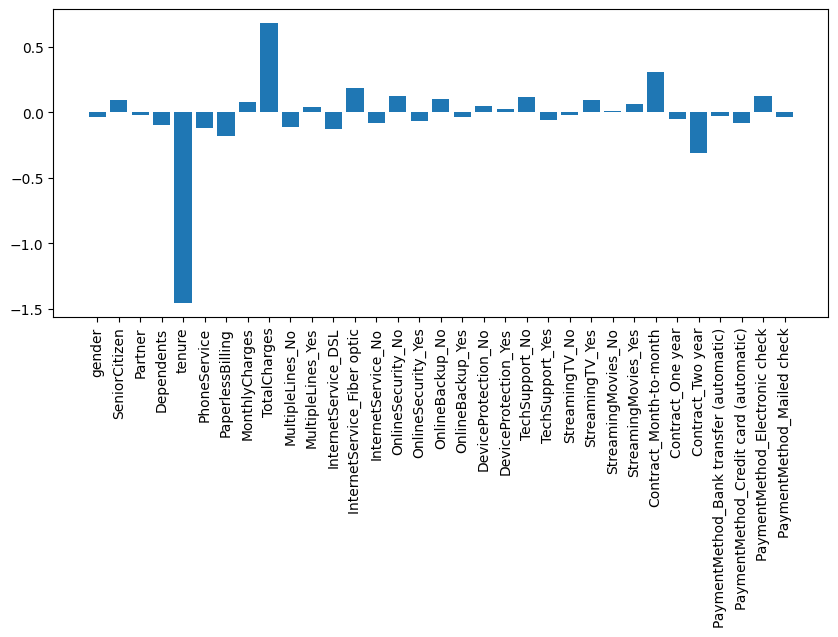

In [119]:
plt.figure(figsize=(10,4))
plt.bar(height=scaled_coefs,x=X.columns)
plt.xticks(rotation=90)
plt.show()

This model has a different opinion about the dominant inputs, with **tenure** and a **two-year** contract being negatively correlated with churn, and **total charges** and **month-to-month payments** being predictive of churn. 

While the coefficients above directly support explainability ambitions, and the non-linear transformation by the sigmoid function (below) complicates the task of reporting the dominant factors. 

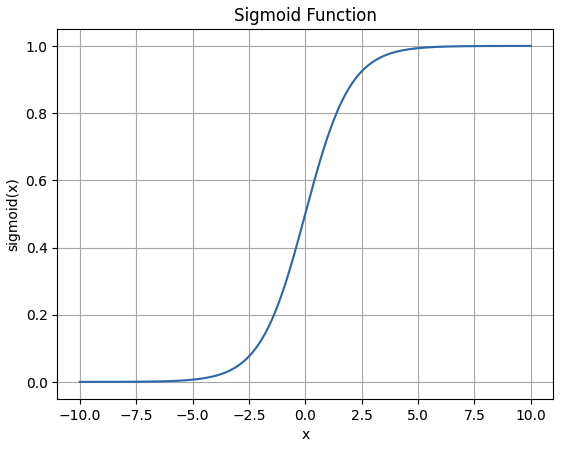

How do we think about the impact of monthly charges or contract length when they are amplified by the sigmoid function at low levels, or suppressed at higher values? The function is obviously reversible, but communicating the *intuition* is not as straightforward. 

From an assumption standpoint: 
- **Linearity**: Our predictors do NOT have a clearly linear relationship to the predictor as shown in the EDA
- **Independence**: Our observations do appear to be independent and uncorrelated
- **Absence of Perfect Separation**: We can see from the earlier EDA distribution plots that no predictor is perfectly correlated with our target
- **Collinearity**: Our observations do not appear to be collinear and are uncorrelated
- **Outliers**: Above distributional plots did not indicate presence of influential outliers
- **Sample size**: We have ~150 samples per predictor 


----- 

### Generalized Additive Model 

The generalized additive model (GAM) implementation comes from the Python [`pygam` library](https://pygam.readthedocs.io/en/latest/). 

In [120]:
from pygam import LinearGAM, s

Here we initialize the model with a spline per feature and train it to learn an optimal representation of the target value using those splines. 

In [121]:
splines = s(0)
for i in range(1, X_train.shape[1]): 
    splines = splines + s(i) 

gam = LinearGAM(splines)

In [122]:
gam.gridsearch(X_train, y_train)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:01 ETA:   0:00:18
 18% (2 of 11) |####                     | Elapsed Time: 0:00:03 ETA:   0:00:17
 27% (3 of 11) |######                   | Elapsed Time: 0:00:05 ETA:   0:00:15
 36% (4 of 11) |#########                | Elapsed Time: 0:00:07 ETA:   0:00:13
 45% (5 of 11) |###########              | Elapsed Time: 0:00:09 ETA:   0:00:11
 54% (6 of 11) |#############            | Elapsed Time: 0:00:11 ETA:   0:00:09
 63% (7 of 11) |###############          | Elapsed Time: 0:00:14 ETA:   0:00:08
 72% (8 of 11) |##################       | Elapsed Time: 0:00:16 ETA:   0:00:06
 81% (9 of 11) |####################     | Elapsed Time: 0:00:18 ETA:   0:00:04
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:20 ETA:   0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23) + s(24) + s(25) + s(26) + s(27) + s(28) + s(29) + s(30) + s(31) + s(32) + intercept,
   tol=0.0001, verbose=False)

With the model fit, we can mine the partial dependencies from the fit operation and plot them to visualize the relevance of each feature compared with a mean prediction. 

In [123]:
plot_columns = X.columns

<Figure size 640x480 with 0 Axes>

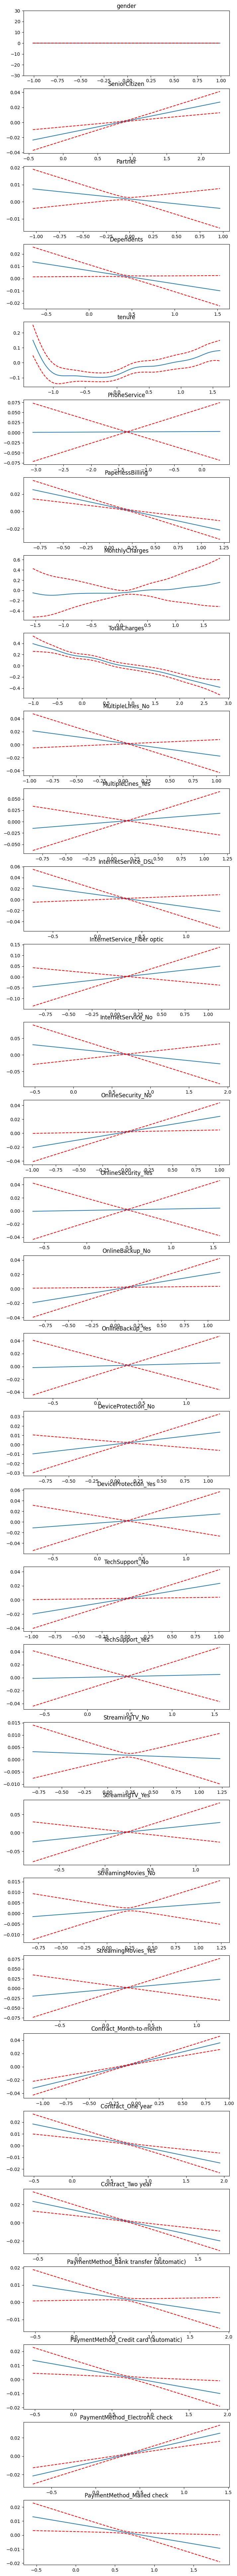

In [124]:
# Code snippet mined from PyGAM documentation here: https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Regression

plt.figure()
fig, axs = plt.subplots(len(plot_columns),1, figsize=(8,100))

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(plot_columns[i]);

In [125]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     43.0726
Link Function:                     IdentityLink Log Likelihood:                                -14802.1256
Number of Samples:                         5634 AIC:                                            29692.3965
                                                AICc:                                           29693.1073
                                                GCV:                                                0.1351
                                                Scale:                                              0.1332
                                                Pseudo R-Squared:                                   0.3235
Feature Function                  Lam

/var/folders/t0/vjz2r6l1155639x6cpfr8z3h0000gn/T/ipykernel_66411/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


We can now run a prediction to determine the performance of the model. 

In [126]:
y_pred = gam.predict(X_test)

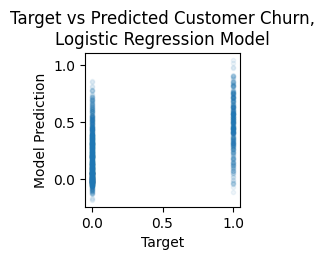

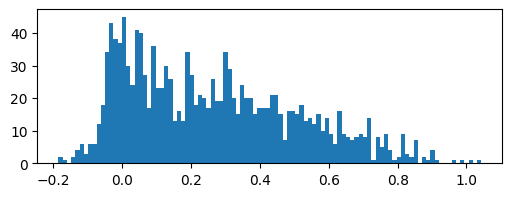

In [127]:
plt.figure(figsize=(2,2))
plt.scatter(x=y_test, y=y_pred, marker='.', alpha=0.07)
plt.xlabel('Target')
plt.ylabel('Model Prediction')
plt.title('Target vs Predicted Customer Churn,\nLogistic Regression Model')
plt.figure(figsize=(6,2))
_ = plt.hist(y_pred, bins=100)

As we are using a regression algorithm here, we are once again in the position of having to predict a binary categorical from a continuous value and so we look the model's performance over a range of classification thresholds. 

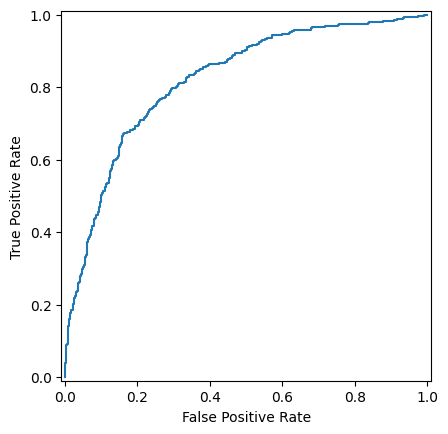

In [137]:
# Note ROC curve interface syntax courtesy of docs @ https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_display_object_visualization.html#sphx-glr-auto-examples-miscellaneous-plot-display-object-visualization-py
fpr, tpr, _ = roc_curve(y_test, y_pred)
rcd = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

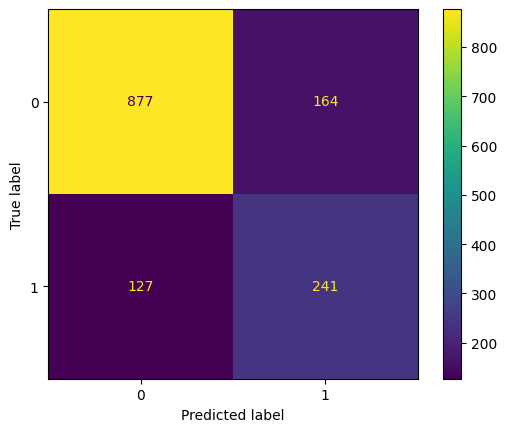

In [138]:
y_binary_pred = threshold_predictions(y_pred, threshold=0.4)
plot_confusion_matrix(y_test, y_binary_pred) 

In [131]:
f1 = f1_score(y_test, y_binary_pred)
print(f"F1 score for GAM: {f1:.3f}")

acc = accuracy_score(y_test, y_binary_pred)
print(f"Accuracy score for GAM @ threshold: {acc:.3f}")

F1 score for GAM: 0.541
Accuracy score for GAM @ threshold: 0.792


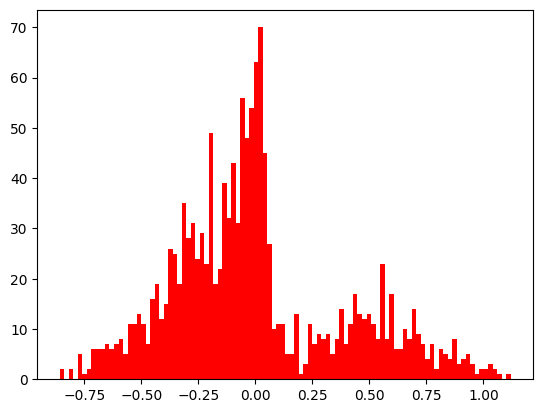

In [132]:
errors = y_test - y_pred
_ = plt.hist(errors, bins=100, color='r')

Text(0, 0.5, 'Prediction Error')

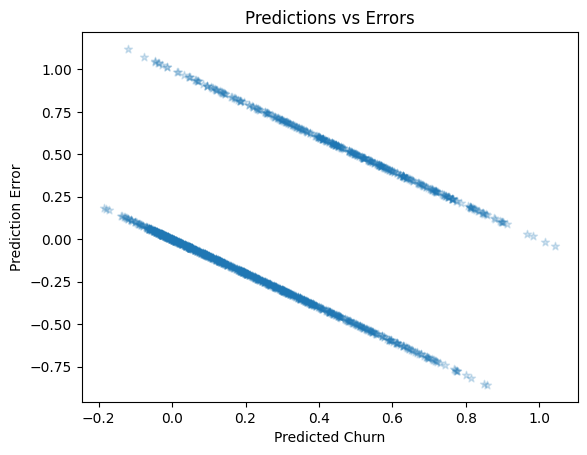

In [133]:
plt.scatter(x=y_pred, y=errors, marker="*", alpha=0.2)
plt.title("Predictions vs Errors")
plt.xlabel("Predicted Churn")
plt.ylabel("Prediction Error")

#### Interpretation

The GAM gives us a full report on the fit splines and allows feature-wise decomposition of the impact. See above exhaustive feature breakout. The dominant factors per the model: 
- positive but variable correlation with churn for **monthly charges**
- negative correlation for **total charges**
- a strong, positive but also variable role for **tenure** (see below)

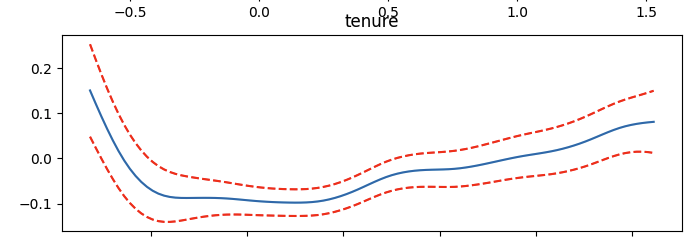

Here we see a much richer decomposition of the tributary factors to our target prediction. Its performance is on par with our prior models. However we have unlocked another level of complexity in interpretability. Trying to explain the above **tenure** plot, for example, to a lay audience may be challenging when viewed through the lens of the other partial dependence plots. It is not possible to tease out whether variance is an artifact of the splines used to compose the prediction or a characteristics of the data itself. 

From an assumptions standpoint, the GAM relaxes some of the constraints of linear regression, though it's not entirely clear how rigid the GAM is on it's assumptions which are called out here. See https://en.wikipedia.org/wiki/Generalized_additive_model. 
- **Composability**: While the exact nature of the relationship between churn and our predictors remains hidden, given the reasonable performance of the above linear models we should expect that an additive strategy can compose a function that approximates the underlying pattern. Though, the use of polynomials to construct the model may induce some non-linearities that complicate explainability. 
- **Independence**: As demonstrated during the EDA stage, we do appear to have independently moving variables
- **Heteroscedacity**: We see in our residual plot that we have what appears to be a bimodel distribution of errors. This is not consistent with the algorithm's prerequisites.  
- **Smoothness**: Related to composability, if we have a ragged non-linear function an additive approach may be an improvement on linear regression, but have be unable to match the variance of the relationship to the target.
- **Degrees of Freedom**: GAMs require us to check that we haven't used an artificially small number of splines during fit, and here we've used one per predictor, hopefully avoiding the unintended amplification of model bias.  

## Comparison of Models

Ultimately, our goal is to predict `churn`, but we must also be able to defend the model's predictions, make sense of it when it falls short of expectations, and explain its operation to our customer. Somewhat surprisingly, our chosen metrics of F1 score and accuracy were more or less at parity across the models we tested. Discussion of each follows. 

**Linear Regression**

This model gives us maximal explainability at the clear expense of model variance. However, in this application, and against at least the test set we held out, it seems to do a passable job. 

- Performance: 
    - F1 @ threshold of 0.5: 0.610
    - Accuracy @ threshold of 0.5: 0.782
- The bias latent in the model's simple linear relationships may give us false confidence in the role of some of our predictors. 
- The violation of some of the prerequisites for linear regression should warrant caution in direct application of its predictions. 
- The simplicity of the coefficients is a powerful communication tool, even if it must be caveated 

**Logistic Regression** 

- Performance: 
    - F1: 0.575
    - Accuracy: 0.798
- This model is the best algorithmic fit of the three, since logistic regression implicitly supports the type of binary classification we are aiming for due to its use of the sigmoid activation
- The relationships reported were more intuitive than that of linear regression, and it may have illuminated some relevant angles for the customer in pursuing reduction of churn
- The sigmoid function complicates the messaging about the role of factors due to that functions nonlinear nature. We can't simply suggest a coefficient in that model drives a proportional output in the prediction due to the compression or amplification of the tributary signals. 

**Generalized Additive Model** 

- Performance: 
    - F1 @ threshold of 0.5: 0.541
    - Accuracy @ threshold of 0.5: 0.792
- This model harbors some distinct potential to dial-in support for complex predictor relationships
- The granularity of the partial dependence data and the associated plots enable a deeper appreciation of how features impact the churn target
- The challenge of explaining the role of the additive spline models is something that we must hold up against the client's desire for interpretability, we may enable granularity of insight at expense of the bigger picture. 

## Recommendation 

As the company desires to not just predict customer churn, but understand the factors that lead to customer churn, we must not just consider the model's ability to perform, but how we can communicate its operation. Enabling the customer to translate insights into preemptive action is paramount. 

While the models differed subtly in their assessment of both the primary factors and their respective magnitude, they all were roughly equivalent in performance based on the metrics we employed. While there is utility in mining the insights of each, and holding those insights up against other data, given our priority is interpretability we must recommend a linear-regression-based modeling approach at the outset. The model's simplicity and trivially explainable machinery will simplify communication and enable us to build a mutually beneficial relationship with this customer. As their interest in applying the technology grows and their staff's ability to employ the associated insights increases, we should look to introduce models with more variance and less bias to improve on linear regression's shortcomings. 